# Checking the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math


Main dataset, saved in NumPy zip archive `/srv/data/shared_ov/datasetMC.npz`, contain three parts:
* `data`: $9840$ magnetic configurations in a form of 2D arrays of size $200\times 200$. The quantity in the arrays is the angle between the local magnetic moment ${\bf m}_{ij}$ and the $z$-axis divided by $\pi$; $\theta_{ij} = \arccos(m_z) / \pi$, where $i,j = 1, 2, \dots, 200$. Therefore, $\theta_{ij} \in \left\langle 0, 1\right\rangle$.
* `values`: pairs of corresponding values of Dzyaloshinskii-Moriya interaction ($D$) and externam magnetic field ($B$)
* `properties`: averaged physical properties corresponding to the values of $D$ and $B$, total magnetization ($M$) and topological charge ($Q$)

Note, there are always $5$ different configurations in *data* calculated at the same values of $D$ and $B$.
In *properties* the quantities are already averaged through the $5$ configurations calculated at thes same values of $D$ and $B$. Thus, in *properties* thre are always 5 identical items.

In [2]:
# load data for classification
Dataset = np.load("data/train/datasetMC.npz")    # load dataset

D = Dataset["data"]           # data: magnetic configurations
V = Dataset["values"]         # values: Dzyaloshiskii-Morya interaction [0] and applied magnetic field [1]
P = Dataset["properties"]     # properties: total magnetization [0] and topological charge [1]

In [3]:
# check shapes
print("Shape of data: {}".format(D.shape))
print("Shape of values: {}".format(V.shape))
print("Shape of properties: {}".format(P.shape))

Shape of data: (9840, 200, 200)
Shape of values: (9840, 2)
Shape of properties: (9840, 2)


In [4]:
# plot total magnetization and topological number

def plot_magnetization_and_topological_number(values, properties):

    # Magnetization
    fig, ax = plt.subplots(figsize=(11,8))

    m = ax.scatter(*values.T, c=(properties.T)[0], cmap="tab10", marker="o", s=60)

    ax.set_title("Magnetization", size=16)
    ax.set_xlabel("D", size=16)
    ax.set_ylabel("B", size=16)

    cbar = fig.colorbar(m, ticks=np.arange(0., 1.01, .1))

    plt.show()

    # Topological number
    fig, ax = plt.subplots(figsize=(11,8))

    m = ax.scatter(*values.T, c=(properties.T)[1], cmap="plasma", marker="o", s=60)

    ax.set_title("Topological number", size=16)
    ax.set_xlabel("D", size=16)
    ax.set_ylabel("B", size=16)


    cbar = fig.colorbar(m)

    plt.show()

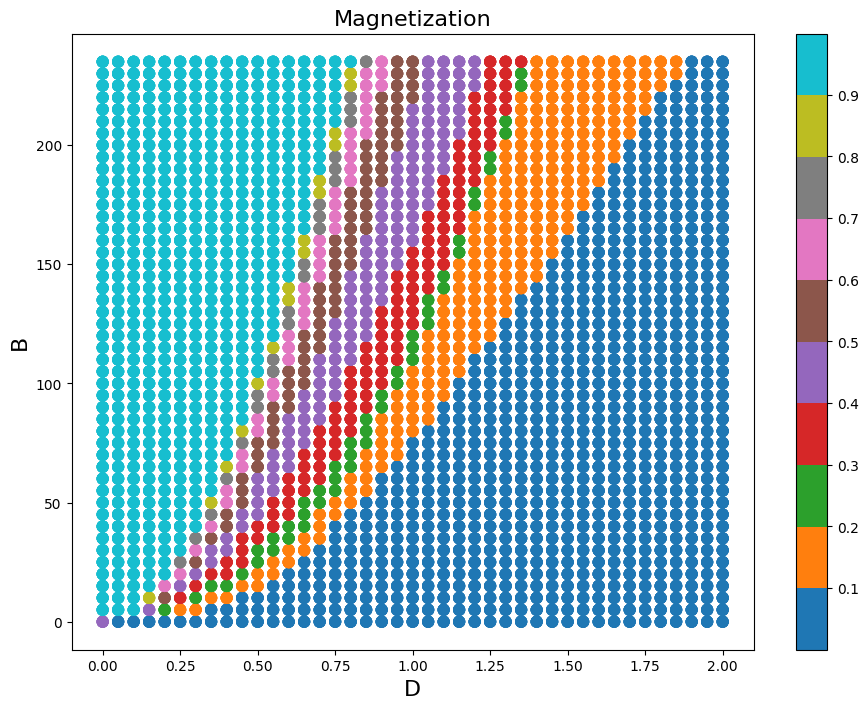

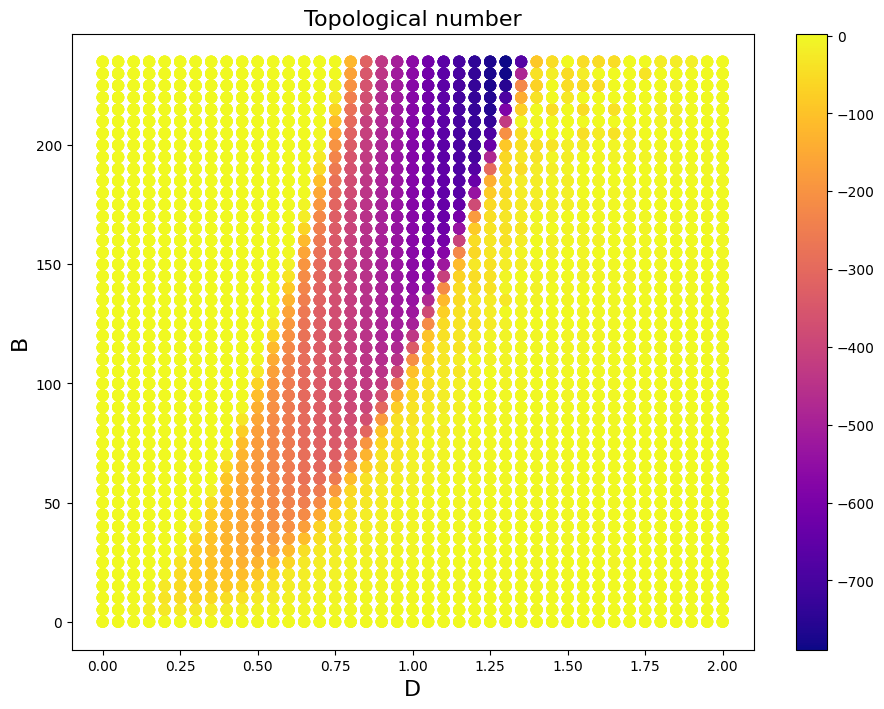

In [5]:
plot_magnetization_and_topological_number(values=Dataset["values"], properties=Dataset["properties"])

In [6]:
def visualize_images(images: np.ndarray, labels=None, row_size: int = 1) -> None:
        """
        Visualize a grid of images with their corresponding labels.

        Args:
            images (np.ndarray): Array of images to visualize.
            row_size (int): Number of images per row in the grid.
        """

        Nsamp = np.arange(len(images))
        n_rows = math.ceil(len(Nsamp) / row_size)

        fig, axs = plt.subplots(
            n_rows, row_size, 
            figsize=(3 * row_size, 3 * n_rows), 
            sharey=True
        )

        # Flatten axs for simpler indexing, in case of a single row
        axs = axs.ravel() if len(Nsamp) > 1 else [axs]

        for n, num_sample in enumerate(Nsamp):
            im = axs[n].imshow(images[num_sample], vmin=0.0, vmax=1.0, cmap="RdBu")

            axs[n].set_xlim((0.0, 200.0))
            axs[n].set_ylim((0.0, 200.0))

            if labels is not None:
                axs[n].text(
                    100, 185, f"{np.round(np.array(labels[num_sample]), 2)}",
                    color="black", size=12, ha="center", va="top",
                    bbox=dict(facecolor="yellow", edgecolor="black", alpha=0.7),
                )

            axs[n].axis("off")  

        for n in range(len(Nsamp), len(axs)):
            axs[n].axis("off")

        fig.subplots_adjust(wspace=0.03)
        plt.show()

# Phase transitions

In this section we will locate the data near the phase transitions (ferromagnet -> skyrmion and skyrmion -> spiral). We don't have a robust way to label such states. Usually some portion of an image is in one phase and the other portion of an image is in the other phase. What can we do without the labels?

One idea comes from the observation that for a ferromagnetic phase, for fixed value of magnetic field B, with increasing D we will continuosly and monotonly transition into skyrmion phase. And if we increase D even further, we will in the same way reach spiral phase. We can use this to define a metric that would (for fixed B data) evaluate the order of predictions agains the order given by the values of D.

## Metric for evaluating phase transitions

The basic idea for such metric might be that it would penalize out-of-order predictions. Remember that we have always 5 images for the same pair of values ($B$, $D$), therefore we can include also some consistency term across these samples into our metric. Another potential term could evaluate the smoothness of the transitions, where we prefer steady change in the predicted probabilities, rather than steep changes.

To evaluate the models performance on phase transitions, we define three metrics: **out-of-order** error, **in-group variance**, and **transition smoothness**.

1. **Out-of-order** error measures the discrepancy between the predicted ranking of images and their true ordering based on phase transition parameters. Given a dataset of images grouped by fixed value of $D$ and ordered by value of $B$, we use our model to evaluate the probability of the dominant phase and use it to assing ranks (predicted order) to the images. The predicted ordering 
$\hat{r}$​ is then compared to the true ordering $r$​ using the Euclidean norm. A lower value of $O$ indicates a better alignment with the expected progression of phase transitions.

$$ O = \left\| \hat{r} - r \right\| $$


2. **In-group variance** assesses the stability of predictions within groups of five equivalent images simulated under identical parameters $B$ and $D$. For each rank $r$, we compute the variance of the predicted probabilities pipi​ across all images in that group and sum over all ranks. A lower variance $V$ indicates that the model consistently predicts the same phase probabilities for equivalent inputs.

$$ V = \sum_r \mathrm{Var}(p_i \mid \hat{r}_i = r) $$

3. **Transition smoothness** quantifies how gradually the predicted phase probabilities evolve across ranks. For each predicted rank $r$, we compute the mean probability vector $\mu_r$​ and evaluate the average absolute change between $N$ successive ranks. A lower value $S$ indicates a more continuous phase transition, suggesting that the model model is able to correctly evaluate also the subtle changes in configurations.

$$ S = \frac{1}{N-1} \sum_{r=1}^{N-1} \left\| \mu_{r+1} - \mu_r \right\|, $$

We will evaluate these metrics after each epoch during the training and we can see if and how is the the model improving.



## Creating the transitions dataset

In [7]:
# We want to create two datasets, one for each transition

# Conditions for filtering fe-sk and sk-sp phase transitions
# (these conditions are derived heuristically based on the Magnetization and Topological number plots)

properties = Dataset["properties"]
magnetization = properties[:, 0]
topological_number = properties[:, 1]

condition_fe_sk = (
    ((magnetization < 0.9982) & 
    (magnetization > 0.75)) 
)

condition_sk_sp = (
    ((magnetization < 0.35) & 
    (magnetization > 0.14)) &
    (topological_number < - 80)
)

transition_conditions = (
    condition_fe_sk |
    condition_sk_sp
)

In [8]:
data_both_transitions = {
    key: Dataset[key][transition_conditions] for key in Dataset.keys()
}
data_both_transitions["data"].shape

(825, 200, 200)

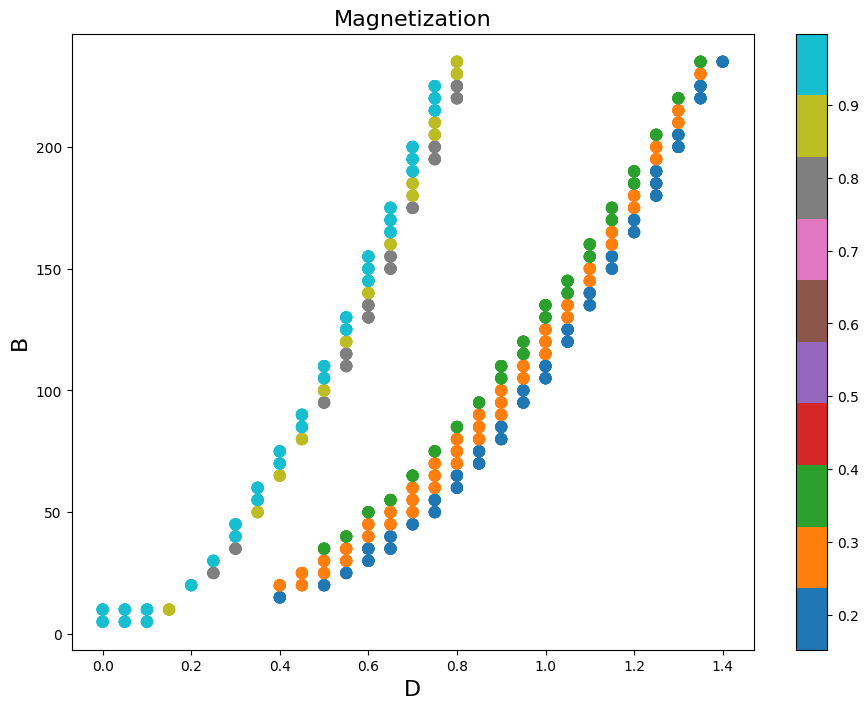

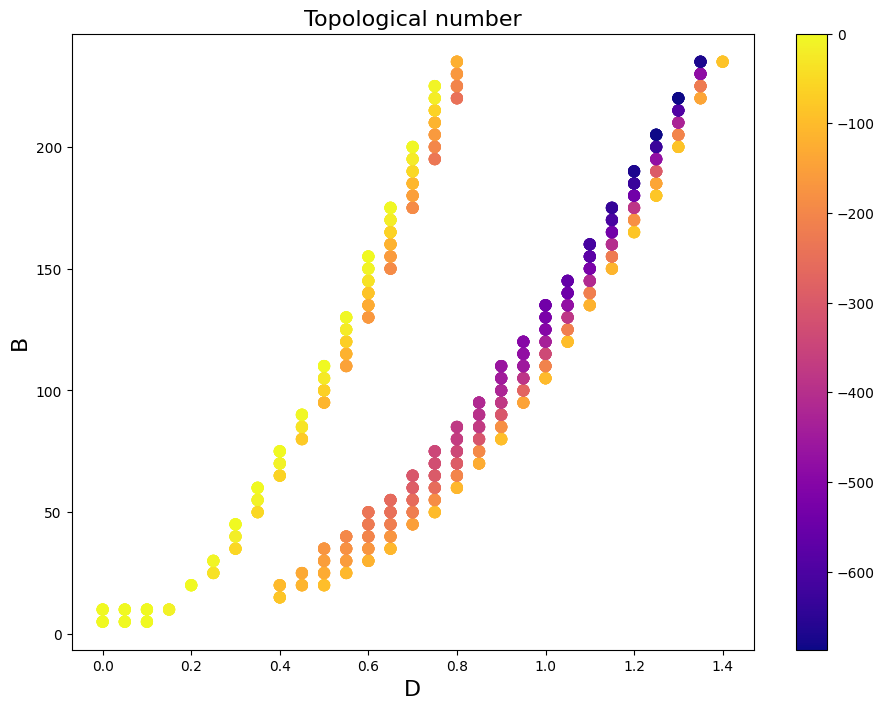

In [9]:
plot_magnetization_and_topological_number(values=data_both_transitions["values"], properties=data_both_transitions["properties"])

In [10]:
def create_transition_dataset(Dataset, condition):

    dataset = {
        key: Dataset[key][condition] for key in Dataset.keys()
    }

    data = dataset["data"]
    values = dataset["values"]
    # properties = dataset["properties"]

    D = np.round(values[:, 0], decimals=2)
    B = np.round(values[:, 1], decimals=2)
    data_trans = {}

    for d_value in np.unique(D):
        indices = np.where(D == d_value)

        b_values, b_labels = np.unique(B[indices], return_inverse=True)

        if len(b_values) <= 5: # if there are 5 or less unique values of B we will not use the data
            continue

        data_trans[str(d_value)] = {"images": data[indices], "labels": b_labels}

    return data_trans

In [11]:
data_trans_fe_sk = create_transition_dataset(Dataset, condition_fe_sk)
data_trans_sk_sp = create_transition_dataset(Dataset, condition_sk_sp)

In [ ]:
for D, dataset in data_trans_fe_sk.items():
    print(D)
    visualize_images(dataset["images"], labels=dataset["labels"], row_size=5)
    # visualize_images(dataset["images"][::5], row_size=6) # for a presentation
    # break

In [ ]:
for D, dataset in data_trans_sk_sp.items():
    print(D)
    visualize_images(dataset["images"], labels=dataset["labels"], row_size=5)

In [14]:
np.savez("data/test/fe_sk_transition.npz", data_trans_fe_sk)
np.savez("data/test/sk_sp_transition.npz", data_trans_sk_sp)

# Dataset for checking feature maps

In [15]:
data = Dataset["data"]

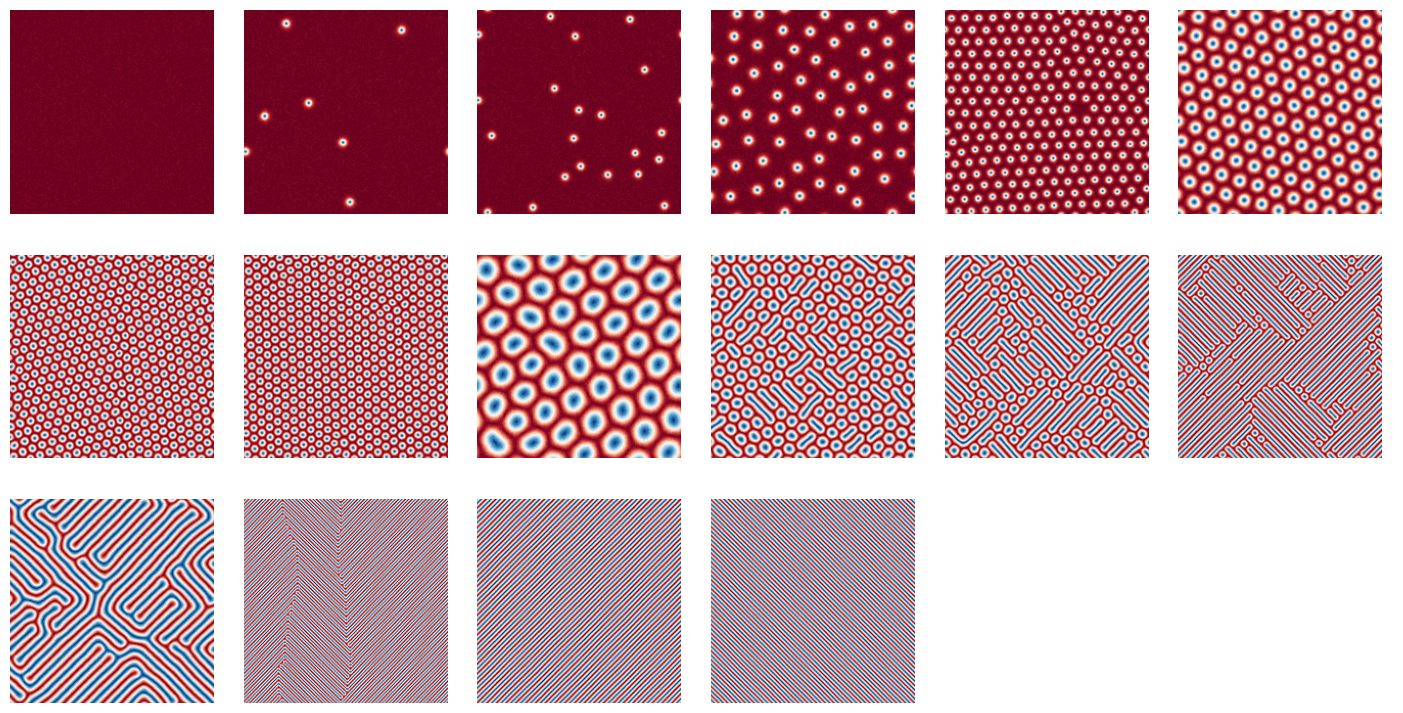

In [16]:
# Nsamp = np.random.choice(range(len(data)), 600)
Nsamp=[181, 2771, 3294, 2503, 4063, 1971, 4221, 4486, 1212, 2921, 3405, 4905, 2400, 9573, 5565, 6240]
visualize_images(data[Nsamp], row_size=6)

In [14]:
fm_dataset = {
    "images": data[Nsamp],
    "labels": np.array(Nsamp)
    }

np.savez("data/test/fm_dataset.npz", fm_dataset)